In [2]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
from scipy.optimize import curve_fit
from matplotlib.colors import LogNorm
import fun.my_functions as mf
from molmass import Formula

1
1


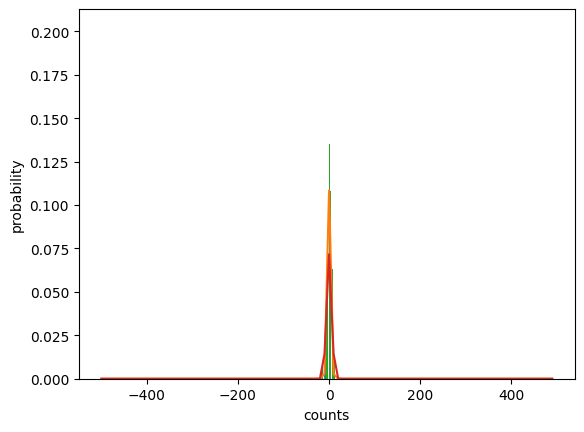

In [3]:
p_data = np.load("../data/jica_datarequest_nr16.npz")
n_data = np.load("../data/jica_datarequest_nr17.npz")
vel_data = np.load("../data/jica_datarequest_nr7.npz")
sc_pot_data = np.load("../data/jica_datarequest_nr10.npz")


spec_p = p_data['p1']
spec_n = n_data['n1']
spec_c_p = spec_p[:-1, :] - spec_p[1:, :]
spec_c_n = spec_n[:-1, :] - spec_n[1:, :]
time = p_data['time']
velocity = vel_data['speed'] * 1e3
sc_pot = sc_pot_data['scpot']

e_bins_p = mf.energy_calibration('p')[:-1] # because loosing one bin in error correction
density_p = mf.calc_current(spec_c_p, 'p1')
e_bins_n = mf.energy_calibration('n')[:-1]
density_n = mf.calc_current(spec_c_n, 'n1')
e_roi_p = e_bins_p[228:240]
dens_roi_p = density_p[228:240,:]
e_roi_n = e_bins_n[365:375]
dens_roi_n = density_n[365:375, :]

EOI_p = mf.calc_energy(Formula('PC2H5+').mass, sc_pot, velocity, instrument='p')
EOI_n = mf.calc_energy(Formula('CH3Br-').mass, sc_pot, velocity, instrument='n')

In [4]:
# fit gaussian and calc area under curve
# for n
area_n = np.zeros(len(time))
amp_n = np.zeros(len(time))
std_n = np.zeros(len(time))

for i in  range(len(time)): 
    #plt.plot(e_roi_n, -dens_roi_n[:,i], label=f't={time[i]}')
    popt, pcov = curve_fit(mf.gauss_fixed_mean_n, e_roi_n, -dens_roi_n[:,i])
    amp_n[i], std_n[i] = popt
    #x_vals = np.linspace(e_roi_n.min(), e_roi_n.max())
    #plt.plot(x_vals, mf.gauss_fixed_mean_n(x_vals, amp_n[i], std_n[i]), 'darkorange', label="Fit")
    area_n[i] = amp_n[i] * np.abs(std_n[i]) * np.sqrt(2 * np.pi)

# for p
area_p = np.zeros(len(time))
amp_p = np.zeros(len(time))
std_p = np.zeros(len(time))

for i in range(len(time)):
    #plt.plot(e_roi_p, dens_roi_p[:,i], label=f't={time[i]}')
    popt, pcov = curve_fit(mf.gauss_fixed_mean_p, e_roi_p, dens_roi_p[:,i])
    amp_p[i], std_p[i] = popt
    #x_vals = np.linspace(e_roi_p.min(), e_roi_p.max())
    #plt.plot(x_vals, mf.gauss_fixed_mean_p(x_vals, amp_p[i], std_p[i]), 'darkorange', label="Fit")
    area_p[i] = amp_p[i] * np.abs(std_p[i]) * np.sqrt(2 * np.pi)

area_n[np.where(std_n > 10)] = 0
area_p[np.where(std_p > 10)] = 0
#plt.legend()
#plt.yscale('log')

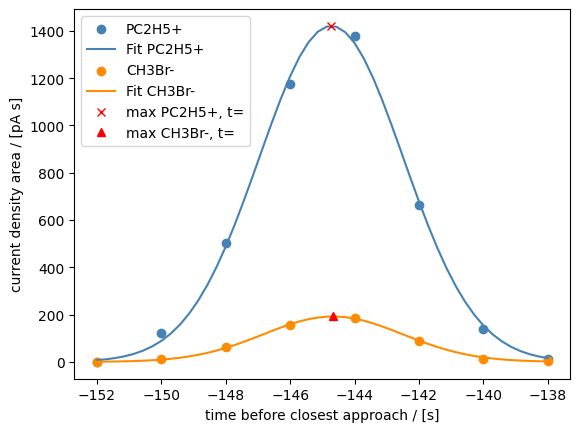

In [5]:
# fit p
A0 = area_p.max() - area_p.min()          # amplitude
mu0 = time[np.argmax(area_p)]           # center
sigma0 = (time.max() - time.min())/6  # rough width estimate
p0 = [mu0, A0, sigma0]
popt, pcov = curve_fit(mf.gauss, time, area_p, p0=p0)
mean_pf, amp_pf, std_pf = popt
# fit n
A0 = area_n.max() - area_n.min()          # amplitude
mu0 = time[np.argmax(area_n)]           # center
sigma0 = (time.max() - time.min())/6  # rough width estimate
p0 = [mu0, A0, sigma0]
popt, pcov = curve_fit(mf.gauss, time, area_n, p0=p0)
mean_nf, amp_nf, std_nf = popt


# plot
x_vals = np.linspace(time.min(), time.max())
plt.scatter(time, area_p, label='PC2H5+', color='steelblue')
plt.plot(x_vals, mf.gauss(x_vals, mean_pf, amp_pf, std_pf), 'steelblue', label="Fit PC2H5+")
plt.scatter(time, area_n, label='CH3Br-', color='darkorange')
plt.plot(x_vals, mf.gauss(x_vals, mean_nf, amp_nf, std_nf), 'darkorange', label="Fit CH3Br-")
plt.plot(mean_pf, amp_pf, 'rx', label=f'max PC2H5+, t=')
plt.plot(mean_nf, amp_nf, 'r^', label=f'max CH3Br-, t=')

# plot parameters
plt.ylabel('current density area / [pA s]')
plt.xlabel('time before closest approach / [s]')
plt.legend()

/tmp/ipykernel_109056/824298753.py:1: RuntimeWarning: divide by zero encountered in divide
  ratio = area_n / area_p


Text(0.5, 0, 'time before closest approach / [s]')

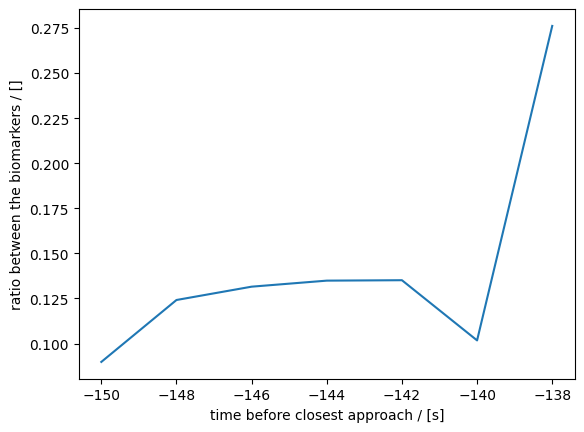

In [6]:
ratio = area_n / area_p
plt.plot(time, ratio)
plt.ylabel('ratio between the biomarkers / []')
plt.xlabel('time before closest approach / [s]')
#plt.legend()

In [7]:
amp_nf / amp_pf

np.float64(0.13505850275494485)